In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
tb_user_curriculum_lecture_unit_solve = pd.read_csv("tables/tb_user_curriculum_lecture_unit_solve.csv")

tb_problems = pd.read_csv("tables/tb_problems.csv")

tb_curriculum_unit = pd.read_csv("tables/tb_curriculum_unit.csv")

In [3]:
### 3등급 커리큘럼 예상 풀이시간 기준으로 작성
difficulty2duration = {
    1.0: 0.75,
    2.0: 0.75,
    3.0: 1.0,
    4.0: 1.5,
    5.0: 2.5,
    6.0: 7,
    7.0: 10,
}
difficulty2duration = {k: v * 60 for k, v in difficulty2duration.items()}

In [4]:
df = tb_user_curriculum_lecture_unit_solve.merge(tb_problems).sort_values("seq").reset_index(drop=True)
df = df[df.notnull()["category3"]].reset_index(drop=True)

In [5]:
df

,seq,cunitSeq,userSeq,question_id,answer,isCorrect,duration,regdate,difficulty_cd,category1,category2,category3,category4,category5
0,2,1718,6,988,2,N,280,2021-04-01 00:00:00,1.0,1 다항식,01 다항식의 연산,01 다항식의 연산,[1] 다항식의 덧셈과 뺄셈,[유형 01 1] 다항식의 덧셈과 뺄셈
1,3,1723,6,29,2,N,112,2021-04-01 00:00:00,3.0,1 다항식,01 다항식의 연산,02 다항식의 곱셈공식,[5] 곱셈 공식의 변형-문자가 2개,[유형 06 1] 문자가 2개인 곱셈 공식의 변형
2,6,1738,6,304,1,N,123,2021-04-01 00:00:00,2.0,2 방정식과 부등식,05 이차방정식,03 이차방정식의 근과 계수의 관계,[8] 근과 계수의 관계를 이용하여 식의 값 구하기(1),[유형 09 1] 식의 값 구하기-근과 계수의 관계 이용
3,7,1738,6,305,4,Y,234,2021-04-01 00:00:00,3.0,2 방정식과 부등식,05 이차방정식,03 이차방정식의 근과 계수의 관계,[9] 근과 계수의 관계를 이용하여 식의 값 구하기(2),"[유형 10 1] 식의 값 구하기-근과 계수의 관계,이차방정식의 해 이용"
4,10,1721,6,13164,③,N,6,2021-04-02 15:44:34,2.0,1 다항식,01 다항식의 연산,02 다항식의 곱셈공식,[3] 곱셈 공식을 이용한 다항식의 전개,[유형 04 1] 곱셈 공식을 이용한 다항식의 전개
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235391,235490,359698,10731,2347,④,Y,77,2022-05-16 13:25:56,2.0,1 다항식,01 다항식의 연산,03 다항식의 나눗셈,[12] 조립제법,[유형 14 1] 조립제법 - 다항식 x+a로 나누는 경우
235392,235491,359698,10731,2346,④,Y,32,2022-05-16 13:26:30,2.0,1 다항식,01 다항식의 연산,03 다항식의 나눗셈,[12] 조립제법,[유형 14 1] 조립제법 - 다항식 x+a로 나누는 경우
235393,235492,359698,10731,55,7,Y,66,2022-05-16 13:27:38,2.0,1 다항식,01 다항식의 연산,03 다항식의 나눗셈,[12] 조립제법,[유형 14 1] 조립제법 - 다항식 x+a로 나누는 경우
235394,235493,359698,10731,1065,19,Y,33,2022-05-16 13:28:13,2.0,1 다항식,01 다항식의 연산,03 다항식의 나눗셈,[12] 조립제법,[유형 14 1] 조립제법 - 다항식 x+a로 나누는 경우


In [6]:
u_list = np.unique(df["userSeq"].values)
u2idx = {u: i for i, u in enumerate(u_list)}

In [7]:
u_list.shape

(538,)

In [8]:
c_list = np.unique(df["category2"].values)
c2idx = {c: i for i, c in enumerate(c_list)}

In [9]:
c_list.shape

(37,)

In [10]:
d_list = np.unique(df["difficulty_cd"].values)
d2idx = {d: i for i, d in enumerate(d_list)}

In [11]:
d_list

array([1., 2., 3., 4., 5., 6., 7.])

In [21]:
def get_response(r, TR):
    return r * (1.50 - np.minimum(np.maximum(TR, 0.65), 1.50)) / (1.50 - 0.65)

In [27]:
seq_lens = []

c_seqs = []
d_seqs = []
r_seqs = []

for u in u_list:
    df_u = df[df["userSeq"] == u]
    
    c_seq = np.array([c2idx[c] for c in df_u["category2"].values])
    d_seq = np.array([d2idx[d] for d in df_u["difficulty_cd"].values])
    
    T_seq = df_u["duration"].values
    T_hat_seq = np.array([difficulty2duration[d_list[d]] for d in d_seq])
    TR_seq = T_seq / T_hat_seq
    
    r_seq = (df_u["isCorrect"].values == "Y").astype(float)
    r_seq = get_response(r_seq, TR_seq)
    
    seq_lens.append(c_seq.shape[0])
    
    c_seqs.append(c_seq)
    d_seqs.append(d_seq)
    r_seqs.append(r_seq)


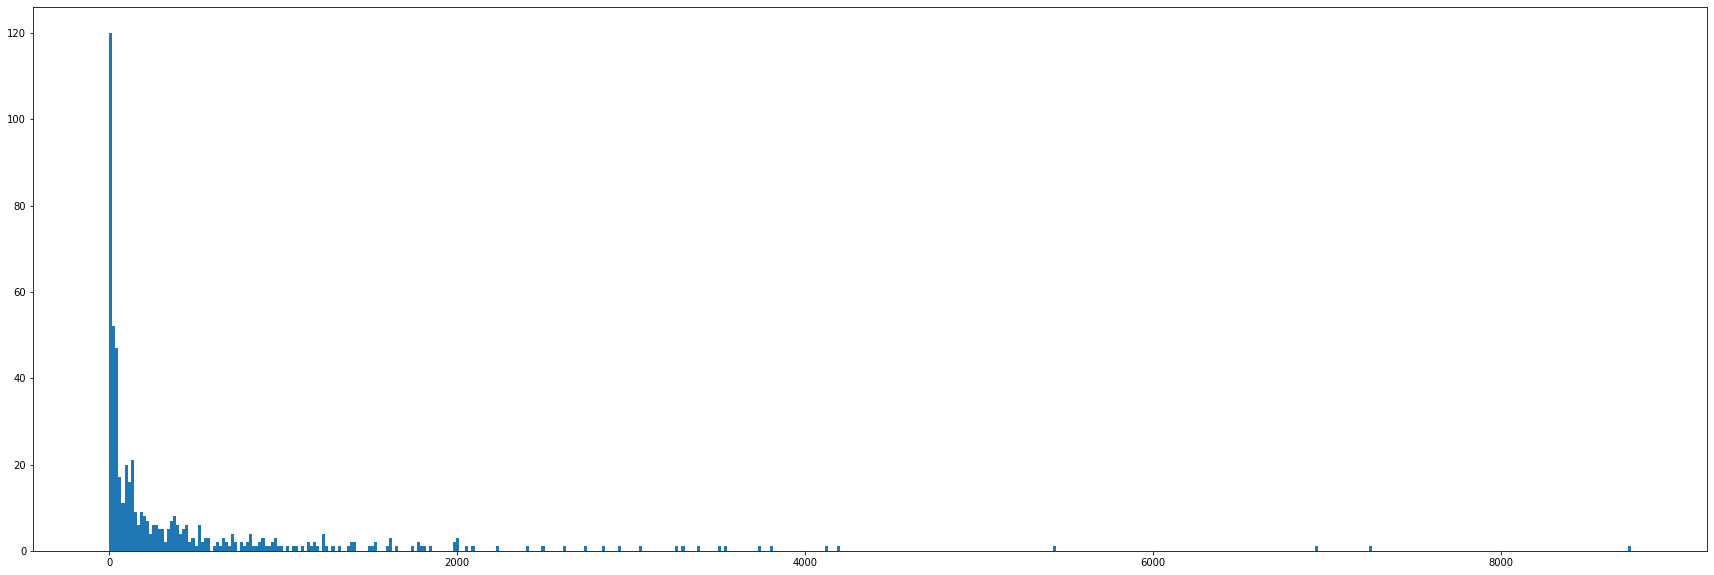

In [15]:
plt.figure(figsize=[30, 10], facecolor="white")
plt.hist(seq_lens, bins=500)
plt.show()

In [28]:
c_seqs

[array([ 0,  0, 18, ...,  0,  0, 25]),
 array([30, 30, 30, 30, 30,  0,  0, 30, 30, 30, 30, 30, 30, 30, 30,  0,  0,
         0,  0,  0,  0]),
 array([ 0, 26, 26, 26, 26, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36,
        36, 36, 36, 35, 35, 35, 35, 12, 12, 35, 35, 35, 35, 35, 35, 35, 36,
        36, 36, 36, 34, 34, 34, 33, 34, 34, 34, 34, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 33, 33, 33, 33, 33, 33, 30, 30, 30, 30,
        30, 30, 30, 30, 33, 33, 33, 33, 33,  2,  7,  7,  7]),
 array([0, 0]),
 array([30, 30, 30, 30, 33, 33, 33, 30, 30, 30]),
 array([18, 18, 18, 18, 18,  0,  0,  0,  0,  0,  0, 18, 18, 18, 18, 18, 18,
        24, 24, 24, 24, 24, 24, 18, 18, 18, 18, 18, 21, 21, 21, 21,  6, 21,
        21, 21, 21]),
 array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 3

In [34]:
from data_loaders.pulja_data_loader import PuljaDataLoader


data_loader = PuljaDataLoader()

AttributeError: 'PuljaDataLoader' object has no attribute 'c2idx'